# Imports

In [1]:
import networkx
import math
import scipy.optimize
import numpy
import sys
from scipy import linalg
import matplotlib.pyplot as plt
from IPython.display import Image
import pywt
from scipy.fftpack import fft, ifft
import random
import operator
import copy

# Datasets

## Small traffic

In [2]:
small_traffic = {}
small_traffic["path"] = "/home/arlei/Phd/research/network_process/data/small_traffic/"
small_traffic["num_snaps"]=8640

## Large traffic

In [3]:
traffic = {}
traffic["path"] = "/home/arlei/Phd/research/network-process/data/traffic/"
traffic["num_snaps"]=8640

## Wikipedia

In [4]:
#TODO

## Brain

In [5]:
#TODO

# Reading Graph

In [6]:
def read_graph(input_graph_name, input_data_name):
    G = networkx.Graph()
    
    input_graph = open(input_graph_name, 'r')
    
    for line in input_graph:
        line = line.rstrip()
        vec = line.rsplit(',')

        v1 = vec[0]
        v2 = vec[1]
        
        G.add_edge(v1,v2)
    
    input_graph.close()
    
    input_data = open(input_data_name, 'r')
    values = {}
    
    for line in input_data:
        line = line.rstrip()
        vec = line.rsplit(',')
        
        vertex = vec[0]
        value = float(vec[1])
        values[vertex] = value
        
    networkx.set_node_attributes(G, "value", values)
    
    input_data.close()
    
    return G

def read_values(input_data_name, G):
    D = {}
    input_data = open(input_data_name, 'r')

    for line in input_data:
        line = line.rstrip()
        vec = line.rsplit(',')

        vertex = vec[0]
        value = float(vec[1])
        D[vertex] = value

    input_data.close()
    
    F = []
    for v in G.nodes():
        F.append(float(D[v]))
   
    F = numpy.array(F)
    
    return F 

def read_dyn_graph(path, num_snapshots, G):
    FT = []
    for t in range(num_snapshots):
        in_file = path + "_" + str(t) + ".data"
        F = read_values(in_file, G)
        FT.append(F)
        
    return numpy.array(FT)

# Visualizing Graph

In [7]:
def set_f(G,F):
    i = 0
    for v in G.nodes():
        G.node[v]["value"] = F[i]
        i = i + 1
        
def rgb_to_hex(r,g,b):
    return '#%02x%02x%02x' % (r,g,b)

def rgb(minimum, maximum, value):
    minimum = -1
    maximum=1
    minimum, maximum = float(minimum), float(maximum)
    ratio = 2 * (value-minimum) / (maximum - minimum)
    b = int(max(0, 255*(1 - ratio)))
    r = int(max(0, 255*(ratio - 1)))
    g = 255 - b - r
    return rgb_to_hex(r, g, b)

def draw_graph_with_values(G, dot_output_file_name):
    output_file = open(dot_output_file_name, 'w')
    output_file.write("graph G{\n")
    output_file.write("rankdir=\"LR\";\n")
    output_file.write("size=\"10,2\";\n")
    
    maximum = -sys.float_info.max
    minimum = sys.float_info.max
    
    for v in G.nodes():
        if G.node[v]["value"] > maximum:
            maximum = G.node[v]["value"]
            
        if G.node[v]["value"] < minimum:
            minimum = G.node[v]["value"]
                
    
    for v in G.nodes():
        color = rgb(minimum, maximum, G.node[v]["value"])
        output_file.write("\""+str(v)+"\" [shape=\"circle\",label=\"\",style=filled,fillcolor=\""+str(color)+"\",penwidth=\"1\",fixedsize=true,width=\"1\",height=\"1\"];\n")
        #output_file.write("\""+str(v)+"\" [shape=\"circle\",label=\""+str(v)+"\",style=filled,fillcolor=\""+str(color)+"\",penwidth=\"1\",fixedsize=true,width=\"1\",height=\"1\"];\n")

    
    for edge in G.edges():
        output_file.write("\""+str(edge[0])+"\" -- \""+str(edge[1])+"\"[dir=\"none\",color=\"black\",penwidth=\"1\"];\n")
        
	
    output_file.write("}")
    
    output_file.close()

# Computing Eigenvectors and Eigenvalues

In [8]:
def compute_eigenvectors_and_eigenvalues(L):
    lamb, U = linalg.eig(L)
    
    idx = lamb.argsort()   
    lamb = lamb[idx]
    U = U[:,idx]
    
    return U, lamb

# Setting center-radius uniform values

In [9]:
def compute_distances(center, graph):
    distances = networkx.shortest_path_length(graph, center)
    
    return distances

def compute_embedding(distances, radius, graph):
    B = []
    s = 0
    nodes = {}
    for v in graph.nodes():
        if distances[v] <= radius:
            B.append(1)
            s = s + 1
        else:
            B.append(0)
            
    return numpy.array(B)

def generate_dyn_syn(graph, diam, duration, n):
    dyn_graph = []
    Fs = []
    
    for j in range(n):
        v = random.randint(0, len(G.nodes())-1)
        distances = compute_distances(G.nodes()[v], G)

        if diam > duration:
            num_snaps = diam
        else:
            num_snaps = duration
     
        for i in range(num_snaps):
            r = int(i * math.ceil(float(diam)/duration))
        
            F = compute_embedding(distances, r, graph)
            Fs.append(F)
        
    return numpy.array(Fs)

# Stacked graph model

In [10]:
def build_stacked_graph_dense(G, FT):
    GT = networkx.Graph()
    values = {}
    
    for e in G.edges():
        v1 = str(e[0])+"-0"
        v2 = str(e[1])+"-0"
        GT.add_edge(v1, v2)
    
    for t in range(1, FT.shape[0]):
        for e in G.edges():
            v1 = str(e[0])+"-"+str(t)
            v2 = str(e[1])+"-"+str(t)
            GT.add_edge(v1, v2)
                      
    for t in range(0, FT.shape[0]-1):
        for v in G.nodes():
            GT.add_edge(str(v)+"-"+str(t), str(v)+"-"+str(t+1))
            for n in G.neighbors(v):
                GT.add_edge(str(v)+"-"+str(t), str(n)+"-"+str(t+1))
    
    F = []
    for t in range(0, FT.shape[0]):
        i = 0
        for v in G.nodes():
            GT.node[str(v)+"-"+str(t)]["value"] = FT[t][i]
            i = i + 1
    
    for v in GT.nodes():
        F.append(GT.node[v]["value"])
    
    return GT, numpy.array(F)

def values_stacked_graph(F, G, G_unstacked):
    FT = []
    snps = int(len(F)/len(G_unstacked.nodes()))
    
    values = {}
    i = 0
    for v in G.nodes():
        values[v] = F[i]
        i = i + 1
        
    for t in range(snps):
        FT.append([])
        for v in G_unstacked.nodes():
            FT[t].append(values[str(v)+"-"+str(t)])
    
    return numpy.array(FT)

# Spectral Domain Wavelets

## Scaling

In [11]:
def s(x):
    return -5 + 11*x - 6*pow(x, 2) + pow(x, 3)

def g(x):
    a = 2
    b = 2
    x_1 = 1
    x_2 = 2
    
    if x < x_1:
        return pow(x_1, -a)*pow(x, a)
    elif x <= x_2 and x >= x_1:
        return s(x)
    else:
        return pow(x_2, b)*pow(x, -b)

def comp_gamma():
    gn = lambda x: -1 * g(x)
    xopt = scipy.optimize.fminbound(gn, 1, 2)
    return xopt

def h(x, gamma, lamb_max, K):
    lamb_min = float(lamb_max) / K
    return gamma * math.exp(-pow(float(x/(lamb_min * 0.6)), 4))

def comp_scales(lamb_max, K, J):
    lamb_min = float(lamb_max) / K
    s_min = float(1)/lamb_max
    s_max = float(2)/lamb_min
    
    return numpy.exp(numpy.linspace(math.log(s_max), math.log(s_min), J))
    
gamma = comp_gamma()

## Wavelets

In [12]:
def graph_low_pass(lamb, U, N, T, gamma, lamb_max, K):
    s = []
    
    for n in range(0, len(N)):
        s.append([])
        
    for n in range(0, len(N)):
        for m in range(0, len(U)):    
            s_n_m = 0
                
            for x in range(0, len(U)):
                s_n_m = s_n_m + U[n][x] * U[m][x] * h(T[-1] * lamb[x], gamma, lamb_max, K)
                    
            s[n].append(s_n_m)
                
    return s

def graph_wavelets(lamb, U, N, T):
    w = []
    
    for t in range(0, len(T)):
        w.append([])
        for n in range(0, len(N)):
            w[t].append([])
            
    
    for t in range(0, len(T)):
        for n in range(0, len(N)):
            for m in range(0, len(U)):    
                w_t_n_m = 0
                
                for x in range(0, len(U)):
                    w_t_n_m = w_t_n_m + U[n][x] * U[m][x] * g(T[t] * lamb[x])
                    
                w[t][n].append(w_t_n_m)
    
    return w

# Graph Fourier Approaches

## 2D-Fourier

In [13]:
def graph_fourier(F, U):
    lambdas = []

    for i in range(0, len(U)):
        lambdas.append(numpy.dot(F, U[:,i]))    
    
    lambdas = numpy.array(lambdas)

    return lambdas

def graph_fourier_inverse(GF, U):
    F = numpy.zeros(U.shape[0])
    for v in range(U.shape[0]):
        for u in range(U.shape[1]):
            F[v] = F[v] + GF[u]*U[v][u]
    
    return F
    
def fourier_transform(F):
    return fft(F)

def fourier_inverse(FT):
    return ifft(FT)

class TwoDFourier(object):    
        def name(self):
            return "2DFourier"
    
        def set_graph(self, _G):
            self.G = _G
            L = networkx.normalized_laplacian_matrix(G)
            L = L.todense()
            self.U, self.lamb_str = compute_eigenvectors_and_eigenvalues(L)
        
        def transform(self, F):
            """
            """
            f1 = []
            for a in range(F.shape[0]):
                gf = graph_fourier(F[a], self.U)
                f1.append(gf)
    
            f1 = numpy.array(f1)
            f2 = []
            for u in range(f1.shape[1]):
                ft = fourier_transform(f1[:,u])
                f2.append(ft)
        
            f2 = numpy.array(f2)
    
            return f2

        def inverse(self, ftr):
            """
            """
            f1 = []
            for a in range(ftr.shape[0]):
                ft = fourier_inverse(ftr[a])
                f1.append(ft)
    
            f1 = numpy.array(f1).transpose()
            F = []    
    
            for v in range(f1.shape[0]):
                gf = graph_fourier_inverse(f1[v], self.U)
                F.append(gf)
        
            return numpy.array(F)

        def drop_frequency(self, ftr, n):
            coeffs = {}
    
            for i in range(ftr.shape[0]):
                for j in range(ftr.shape[1]):
                    coeffs[(i,j)] = abs(ftr[i][j])
            
            sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
            
            ftr_copy = numpy.copy(ftr)
            
            for k in range(n, len(sorted_coeffs)):
                i = sorted_coeffs[k][0][0]
                j = sorted_coeffs[k][0][1]
        
                ftr_copy[i][j] = 0
                    
            return ftr_copy

class OneDFourier(object):
    def name(self):
        return "1DFourier"
    
    def set_graph(self, _G):
        self.G_unstacked = _G
                
    def transform(self, _F):
        """
        """
        (self.G, self.F) = build_stacked_graph_dense(self.G_unstacked, _F)
        L = networkx.normalized_laplacian_matrix(self.G)
        L = L.todense()
        self.U, self.lamb_str = compute_eigenvectors_and_eigenvalues(L)

        return graph_fourier(self.F, self.U)
    
    def inverse(self, ftr):
        """
        """
        inv_stacked = graph_fourier_inverse(ftr, self.U)
        
        return values_stacked_graph(inv_stacked, self.G, self.G_unstacked)
            
    def drop_frequency(self, ftr, n):
        """
        """
        coeffs = {}
    
        for i in range(len(ftr)):
            coeffs[i] = abs(ftr[i])
            
        sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
        
        ftr_copy = numpy.copy(ftr)
        
        for k in range(n, len(sorted_coeffs)):
            i = sorted_coeffs[k][0]
        
            ftr_copy[i] = 0
          
        return ftr_copy  

def L2(F, F_approx):
    e = 0
    for i in range(F.shape[0]):
        e = e + ((F[i]-F_approx[i])**2).sum()
    
    return float(e)

def L1(F, F_approx):
    e = 0
    for i in range(F.shape[0]):
        e = e + (abs(F[i]-F_approx[i])).sum()
    
    return float(e)
    

## GF+WV

In [14]:
def graph_fourier_wavelets(G, U, FT):
    GF = []
    for t in range(FT.shape[0]):
        gf = graph_fourier(FT[t], U)
        GF.append(gf)
        
    GF = numpy.array(GF).transpose()

    WV = []
    db1 = pywt.Wavelet('db1')

    for f in range(GF.shape[0]):
        coeffs = pywt.wavedec(GF[f], db1)
        WV.append(coeffs)
        
    return WV

def graph_fourier_wavelets_inverse(WV_GF, U):
    GF = []
    for a in range(len(WV_GF)):
        ftr = pywt.waverec(WV_GF[a], 'db1')
        GF.append(ftr)
    
    GF = numpy.array(GF).transpose()
    F = []    
    
    for v in range(GF.shape[0]):
        gf = graph_fourier_inverse(GF[v], U)
        F.append(gf)
        
    return numpy.array(F)

def graph_fourier_wavelets_filter(WV_GF, n):
    coeffs = {}
    
    for i in range(len(WV_GF)):
        for j in range(len(WV_GF[i])):
            for k in range(len(WV_GF[i][j])):
                coeffs[(i,j,k)] = abs(WV_GF[i][j][k])
            
    sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
    
    for k in range(n, len(sorted_coeffs)):
        i = sorted_coeffs[k][0][0]
        j = sorted_coeffs[k][0][1]
        m = sorted_coeffs[k][0][2]
        
        WV_GF[i][j][m] = 0
    
    return WV_GF

# Graph Wavelet Approaches

## Hammond's

In [15]:
def hammond_wavelet_transform(w, s, T, F):
    C = []

    for i in range(len(T)):
        C.append([])
        for j in range(len(F)):
            dotp = numpy.dot(F, w[i][j])
            C[i].append(dotp)
            
    C.append([])
    for j in range(len(F)):
        dotp = numpy.dot(F, s[j])
        C[-1].append(dotp)
                      
    return numpy.array(C)

def hammond_wavelets_inverse(w, s, C):
    w = numpy.array(w)
    Wc = numpy.append(w, numpy.array([s]), axis=0)
    
    nWc = Wc[0,:,:]
    nC = C[0]
    for i in range(1,Wc.shape[0]):
        nWc = numpy.append(nWc, Wc[i,:,:], axis=0)
        nC = numpy.append(nC, C[i], axis=0)
    
    nWc = numpy.array(nWc)
    nC = numpy.array(nC)
    
    F = numpy.linalg.lstsq(nWc, nC)[0]
    
    return F
       
class TwoDHWavelets(object):
        def name(self):
            return "2DWavelets"
        
        def set_graph(self, _G):
            self.G = _G
            L = networkx.normalized_laplacian_matrix(G)
            L = L.todense()
            self.U, self.lamb_str = compute_eigenvectors_and_eigenvalues(L)
            lamb_max = max(self.lamb_str)
            K = 10
            J = 10
            self.T = comp_scales(lamb_max, K, J)
            self.w = graph_wavelets(self.lamb_str, self.U, range(len(G.nodes())), self.T)
            self.s = graph_low_pass(self.lamb_str, self.U, range(len(G.nodes())), self.T, gamma, lamb_max, K)
        
        def transform(self, F):
            """
            """
            f1 = []
            for a in range(F.shape[0]):
                wv = hammond_wavelet_transform(self.w, self.s, self.T, F[a])
                f1.append(wv)
    
            db1 = pywt.Wavelet('db1')
    
            f1 = numpy.array(f1)
            f2 = []
                             
            for a in range(f1.shape[1]):
                f2.append([])
                for v in range(f1.shape[2]):
                    wv = pywt.wavedec(f1[:,a,v], db1)
                    f2[a].append(wv)
        
            return f2
    
        def inverse(self, wtr):
            """
            """
            f1 = []
            for a in range(len(wtr)):
                f1.append([])
                for v in range(len(wtr[a])):
                    wv = pywt.waverec(wtr[a][v], 'db1')
                    f1[a].append(wv)
            F = []    
            f1 = numpy.array(f1).transpose((2,0,1))
                        
            for t in range(f1.shape[0]):
                f = hammond_wavelets_inverse(self.w, self.s, f1[t])
                F.append(f)
        
            return numpy.array(F)

        def drop_frequency(self, wtr, n):
            coeffs = {}
            for i in range(len(wtr)):
                for j in range(len(wtr[i])):
                    for m in range(len(wtr[i][j])):
                        for p in range(len(wtr[i][j][m])):
                            coeffs[(i,j,m,p)] = abs(wtr[i][j][m][p])
                        
            sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
            
            wtr_copy = copy.deepcopy(wtr)
                         
            for k in range(n, len(sorted_coeffs)):
                i = sorted_coeffs[k][0][0]
                j = sorted_coeffs[k][0][1]
                m = sorted_coeffs[k][0][2]
                p = sorted_coeffs[k][0][3]
                
                wtr_copy[i][j][m][p] = 0.0
                
            return wtr_copy

class OneDHWavelets(object):
    def name(self):
        return "1DWavelets"
    
    def set_graph(self, _G):
        self.G_unstacked = _G
                
    def transform(self, _F):
        """
        """
        (self.G, self.F) = build_stacked_graph_dense(self.G_unstacked, _F)
        L = networkx.normalized_laplacian_matrix(self.G)
        L = L.todense()
        self.U, self.lamb_str = compute_eigenvectors_and_eigenvalues(L)
        lamb_max = max(self.lamb_str)
        K = 10
        J = 10
        self.T = comp_scales(lamb_max, K, J)
        self.w = graph_wavelets(self.lamb_str, self.U, range(len(self.G.nodes())), self.T)
        self.s = graph_low_pass(self.lamb_str, self.U, range(len(self.G.nodes())), self.T, gamma, lamb_max, K)

        return hammond_wavelet_transform(self.w, self.s, self.T, self.F)
    
    def inverse(self, wtr):
        """
        """
        inv_stacked =  hammond_wavelets_inverse(self.w, self.s, wtr)
        
        return values_stacked_graph(inv_stacked, self.G, self.G_unstacked)
    
    def drop_frequency(self, wtr, n):
        coeffs = {}
    
        for i in range(wtr.shape[0]):
            for j in range(wtr.shape[1]):
                coeffs[(i,j)] = abs(wtr[i][j])
            
        sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
            
        wtr_copy = numpy.copy(wtr)
            
        for k in range(n, len(sorted_coeffs)):
            i = sorted_coeffs[k][0][0]
            j = sorted_coeffs[k][0][1]
        
            wtr_copy[i][j] = 0
                    
        return wtr_copy

## Gavish's

In [16]:
def build_matrix(G, ind):
    M = []
    dists = all_pairs_shortest_path(G)
    
    M = numpy.zeros((len(G.nodes()), len(G.nodes())))
    
    for v1 in G.nodes():
        for v2 in G.nodes():
            M[ind[v1]][ind[v2]] = dists[v1][v2]
    
    return M

def select_centroids(M, radius):
    nodes = range(M.shape[0])
    rand_nodes = random.shuffle(nodes)
    cents = [rand_nodes[0]]
    
    for i in range(1, len(rand_nodes)):
        add = True
        for j in range(len(cents)):
            if M[cents[j][rand_nodes[i] < radius:
                add = False
                break
        if add:
            cents.append(rand_nodes[i])
                          
    return cents
                          
def coarse_matrix(M, cents):
    Q = numpy.zeros((len(cents), len(cents)))
    assigns = []
    
    for i in range(len(cents)):
        assigns.append([])
                          
    for i in range(M.shape[0]):
        min_dist = M[i][cents[0]]
        min_cent = 0
                          
        for j in range(1, len(cents)):
            if M[i][cents[j]] < min_dist:
                min_dist = M[i][cents[j]]
                min_cent = j
                          
        assigns[min_cent].append(i)
                          
    for i in range(len(cents)):
        for j in range(len(cents)):
            for m in assigns[i]:
                for k in assigns[j]:
                    Q[i][j] = Q[i][j] + pow(M[m][k], 2)
                          
    return Q, assigns
    
def gavish_hierarchy(G, radius):
        H = []
                   
        ind = {}
        i = 0
        for v in G.nodes():
            ind[v] = i
            i = i + 1
            
        M = build_matrix(G, ind)
                          
        while M.shape[0] > 1:
            cents = select_centroids(M, radius)
            Q, assigns = coarser_matrix(M, cents)
            H.append(assigns)
                         
    return H, ind

def gavish_wavelet_transform(tree, ind, G, F):
    avgs = numpy.zeros(F.shape[0])
    i = 0                      
    for v in G.nodes():
       avgs[ind[v]] = F[i]
        i = i + 1
    
    wtr = [avgs]
                          
    for i in range(len(tree)):
        up_avgs = numpy.zeros(len(tree[i]))
        counts = numpy.zeros(len(tree[i]))
        
        for j in range(avgs.shape[0]):
            up_avgs[tree[i][j]] =  up_avgs[tree[i][j]] + avgs[j]
            counts[tree[i][j]] =  counts[tree[i][j]] + 1 
                          
        for j in range(ups_avgs.shape[0]):
            ups_avgs[j] = float(ups_avgs[j]) / counts[j]
        
        wtr.append(ups_avgs)
                          
    return wtr
                          
def gavish_wavelet_inverse(tree, ind, G, wtr):
    

class OneDGWavelets(object):
    def name(self):
        return "1DGWavelets"
    
    def set_graph(self, _G):
        self.G_unstacked = _G
                
    def transform(self, _F):
        """
        """
        (self.G, self.F) = build_stacked_graph_dense(self.G_unstacked, _F)
        (self.tree, self.ind) = gavish_hierarchy(G, 0)
        
        return gavish_wavelet_transform(self.tree, self.ind, self.G, self.F)
    
    def inverse(self, wtr):
        """
        """
        inv_stacked =  gavish_wavelets_inverse(self.tree, self.ind, self.G, wtr)
        
        return values_stacked_graph(inv_stacked, self.G, self.G_unstacked)
    
    def drop_frequency(self, wtr, n):
        coeffs = {}
    
        for i in range(wtr.shape[0]):
            for j in range(wtr.shape[1]):
                coeffs[(i,j)] = abs(wtr[i][j])
            
        sorted_coeffs = sorted(coeffs.items(), key=operator.itemgetter(1), reverse=True)
            
        wtr_copy = numpy.copy(wtr)
            
        for k in range(n, len(sorted_coeffs)):
            i = sorted_coeffs[k][0][0]
            j = sorted_coeffs[k][0][1]
        
            wtr_copy[i][j] = 0
                    
        return wtr_copy    

IndentationError: expected an indented block (<ipython-input-16-a84c3ae44f87>, line 3)

# SVD approach

In [17]:
def svd_transform(FT):
    svd_u, svd_s, svd_v = numpy.linalg.svd(FT, full_matrices=True)
    
    return svd_u, svd_s, svd_v

def svd_inverse(svd_u, svd_s, svd_v):
    svd_S = numpy.zeros((svd_u.shape[1], svd_v.shape[0]), dtype=complex)
    svd_S[:svd_s.shape[0], :svd_s.shape[0]] = numpy.diag(svd_s)
    FT = numpy.dot(svd_u, numpy.dot(svd_S, svd_v))
    
    return numpy.real(FT)

In [18]:
def svd_filter(svd_u, svd_s, svd_v, n):
    for k in range(n, len(svd_s)):
        svd_s[k] = 0
       
    return svd_s    

# Cascade on Karate Club Dataset

In [ ]:
G=networkx.karate_club_graph()
syn_F = generate_dyn_syn(G, 4, 4, 4)

In [ ]:
#set_f(G, FT[1])

#draw_graph_with_values(G, "karate.dot")

#!sfdp -Goverlap=prism -Tsvg karate.dot > karate_1.svg

#from IPython.display import SVG

#SVG(filename='karate_1.svg')

# Small traffic

In [ ]:
#G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")

#FT = read_dyn_graph(small_traffic["path"] + "traffic", 2000, G)   

In [ ]:
#plt.clf()
#heatmap = plt.pcolor(numpy.real(FT))
#plt.ylim(0,2000)
#plt.colorbar(heatmap)
#plt.savefig("fourier_time_graph.png")
#Image(filename='fourier_time_graph.png')

# Compression experiments

In [19]:
def compression_experiment(G, FT, algs):
    comp_ratios = (.01, .02, .04, .08, .16, .32, .64, 1.28, 2.56)

    results = {}
    for alg in algs:
        results[alg.name()] = []
        alg.set_graph(G)
        tr = alg.transform(FT)
        for r in comp_ratios:
            size = int(FT.size * r)
            appx_tr = alg.drop_frequency(tr, size)
            appx_FT = alg.inverse(appx_tr)
            results[alg.name()].append([L2(FT, appx_FT), L1(FT, appx_FT)])
            
        results[alg.name()] = numpy.array(results[alg.name()]) 
                               
    return results

In [20]:
def plot_compression_experiments(results, output_file_name):
    comp_ratios = numpy.array([.01, .02, .04, .08, .16, .32, .64, 1.28, 2.56])
    plt.clf()
    for alg in results.keys():
        plt.plot(comp_ratios, results[alg][:,0])
        
    plt.legend(results.keys())
    
    plt.savefig(output_file_name)

## Karate club

In [33]:
G=networkx.karate_club_graph()
syn_F = generate_dyn_syn(G, 4, 8, 2)

In [37]:
algs = [TwoDHWavelets(), OneDHWavelets(), TwoDFourier(), OneDFourier()]

reskc = compression_experiment(G, syn_F, algs)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: ComplexWarning: Casting complex values to real discards the imaginary part


In [39]:
plot_compression_experiments(reskc, "karate_compression_l2.png")

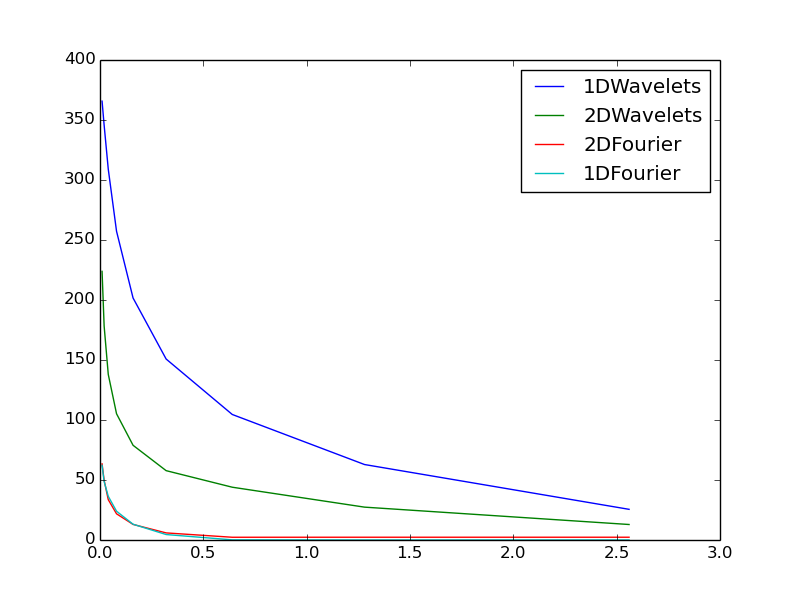

In [40]:
Image(filename="karate_compression_l2.png")

## Small Traffic

In [41]:
G = read_graph(small_traffic["path"] + "traffic.graph", small_traffic["path"] + "traffic_100.data")

FT = read_dyn_graph(small_traffic["path"] + "traffic", 2000, G)  

In [42]:
algs = [TwoDHWavelets(), TwoDFourier()]

restf = compression_experiment(G, FT, algs)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:137: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: ComplexWarning: Casting complex values to real discards the imaginary part


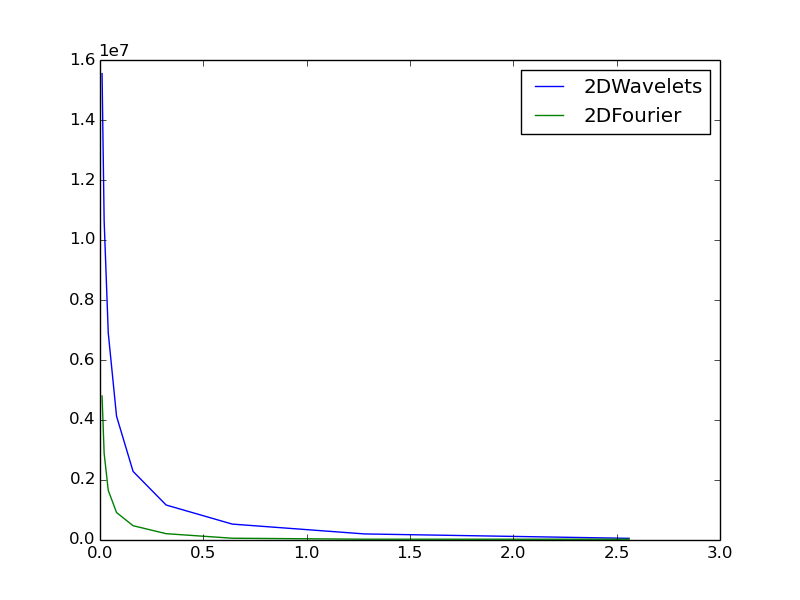

In [43]:
plot_compression_experiments(restf, "karate_compression_l2.png")
Image(filename="karate_compression_l2.png")

In [25]:
print res

{'2DWavelets': array([[ 15545202.63073381,   1184390.44019413],
       [ 10650917.09832454,    975068.73459017],
       [  6898072.05530147,    778877.82638619],
       [  4128380.96786282,    598706.22803493],
       [  2286844.95282959,    442693.00304149],
       [  1166271.98626584,    317413.43745722],
       [   530050.45375431,    221785.77765455],
       [   202138.06638332,    144757.90799114],
       [    55651.29385415,     78901.90003025]])}
